# Imports and Functions

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import random
import time
from tqdm import tqdm
from itertools import combinations
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import datetime
import math
from scipy.stats import norm, kurtosis, mode
cmap = plt.get_cmap('tab10')
from scipy.stats import describe
import seaborn as sns
from matplotlib.pyplot import figure

In [6]:
def one_simulation(p_out,G_input, N_walkers,initial_node_with_walkers,run_time):
    end_time_list = []
    r_square_re = []
    for iter_num in range(run_time):
        #G = G_ba.copy()
        G = G_input.copy()
        N_nodes = len(G.nodes())

        ### Asign the walker
        nx.set_node_attributes(G, [0],'history')
        initial_walkers = random.sample(range(N_nodes),initial_node_with_walkers)
        for i in initial_walkers:
            G.nodes[i]['history'] = [N_walkers / initial_node_with_walkers]
        
        degree_of_initial = [G.degree(k) for k in initial_walkers]

        # the x (expected final distribution of walkers) of the linear regression
        walker_per_degree = N_walkers/sum([j for (i,j) in G.degree])
        degree_list = np.array([j*walker_per_degree for (i,j) in G.degree])
        degree_list = degree_list.reshape(-1,1)
        
        # Run the simulation model until the R-square over 0.99
        linear_score = [0]
        end_time = 0
        while linear_score[-1] <0.99:
            end_time += 1
            for nodes in G.nodes:
                tem_out_list = [n for n in G.neighbors(nodes)]
                tem_in_node = 0
                for neigh_node in tem_out_list:
                    tem_in_node += G.nodes[neigh_node]['history'][end_time-1] * p_out / len([n for n in G.neighbors(neigh_node)])
                G.nodes[nodes]['history'] = G.nodes[nodes]['history']+[tem_in_node + G.nodes[nodes]['history'][end_time-1] * (1-p_out)]
            ## Run the linear regression
            check_list = []
            for nodes in G.nodes:
                check_list.append(G.nodes[nodes]['history'][-1])
            reg = LinearRegression().fit(degree_list, check_list)
            linear_score.append(round(reg.score(degree_list, check_list),4))
        # record the end time of each simulation    
        end_time_list.append(end_time)
        
    return end_time_list


# Figure 4A: ER and BA graphs. Nodes  1k. Average degre 5.9. Diffusion probability 0.1, 0.2, 0.4, 0.6, 0.8, 1.0.

In [7]:
p_out_list = [0.1,0.2,0.4,0.6,0.8,1.0]
end_time_all_ER = []
end_time_all_BA = []
## k_avg = 6.3
m = 3
n=1000
N_walkers = 400
initial_node_with_walkers = 8
run_time = 100

G_BA = nx.barabasi_albert_graph(n, m)
k_avg = np.mean([G_BA.degree(node_BA) for node_BA in list(G_BA.nodes())])
print('Average degree: ', k_avg)
p = k_avg / (n-1)
G_ER = nx.erdos_renyi_graph(n, p)

for p_out in tqdm(p_out_list):

    end_time_list_ER = one_simulation(p_out,G_ER, N_walkers, initial_node_with_walkers, run_time)
    end_time_list_BA = one_simulation(p_out,G_BA, N_walkers, initial_node_with_walkers, run_time)
    
    end_time_all_ER.append(end_time_list_ER)
    end_time_all_BA.append(end_time_list_BA)

Average degree:  5.982


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [13:57<00:00, 139.56s/it]


In [8]:
np.save('end_time_all_ER_4a.npy', np.array(end_time_all_ER))
np.save('end_time_all_BA_4a.npy', np.array(end_time_all_BA))

# Plot

In [2]:
end_time_all_ER = np.load('end_time_all_ER_4a.npy')
end_time_all_BA = np.load('end_time_all_BA_4a.npy')

In [6]:
p_out_list = [0.1,0.2,0.4,0.6,0.8,1.0]

In [3]:
end_time_median_ER = []
end_time_95_percentile_ER = []
end_time_5_percentile_ER = []

for l in tqdm(end_time_all_ER):
    end_time_median_ER.append(np.percentile(l, 50))
    end_time_95_percentile_ER.append(np.percentile(l, 95))
    end_time_5_percentile_ER.append(np.percentile(l, 5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2742.57it/s]


In [4]:
end_time_median_BA = []
end_time_95_percentile_BA = []
end_time_5_percentile_BA = []

for l in tqdm(end_time_all_BA):
    end_time_median_BA.append(np.percentile(l, 50))
    end_time_95_percentile_BA.append(np.percentile(l, 95))
    end_time_5_percentile_BA.append(np.percentile(l, 5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1851.65it/s]


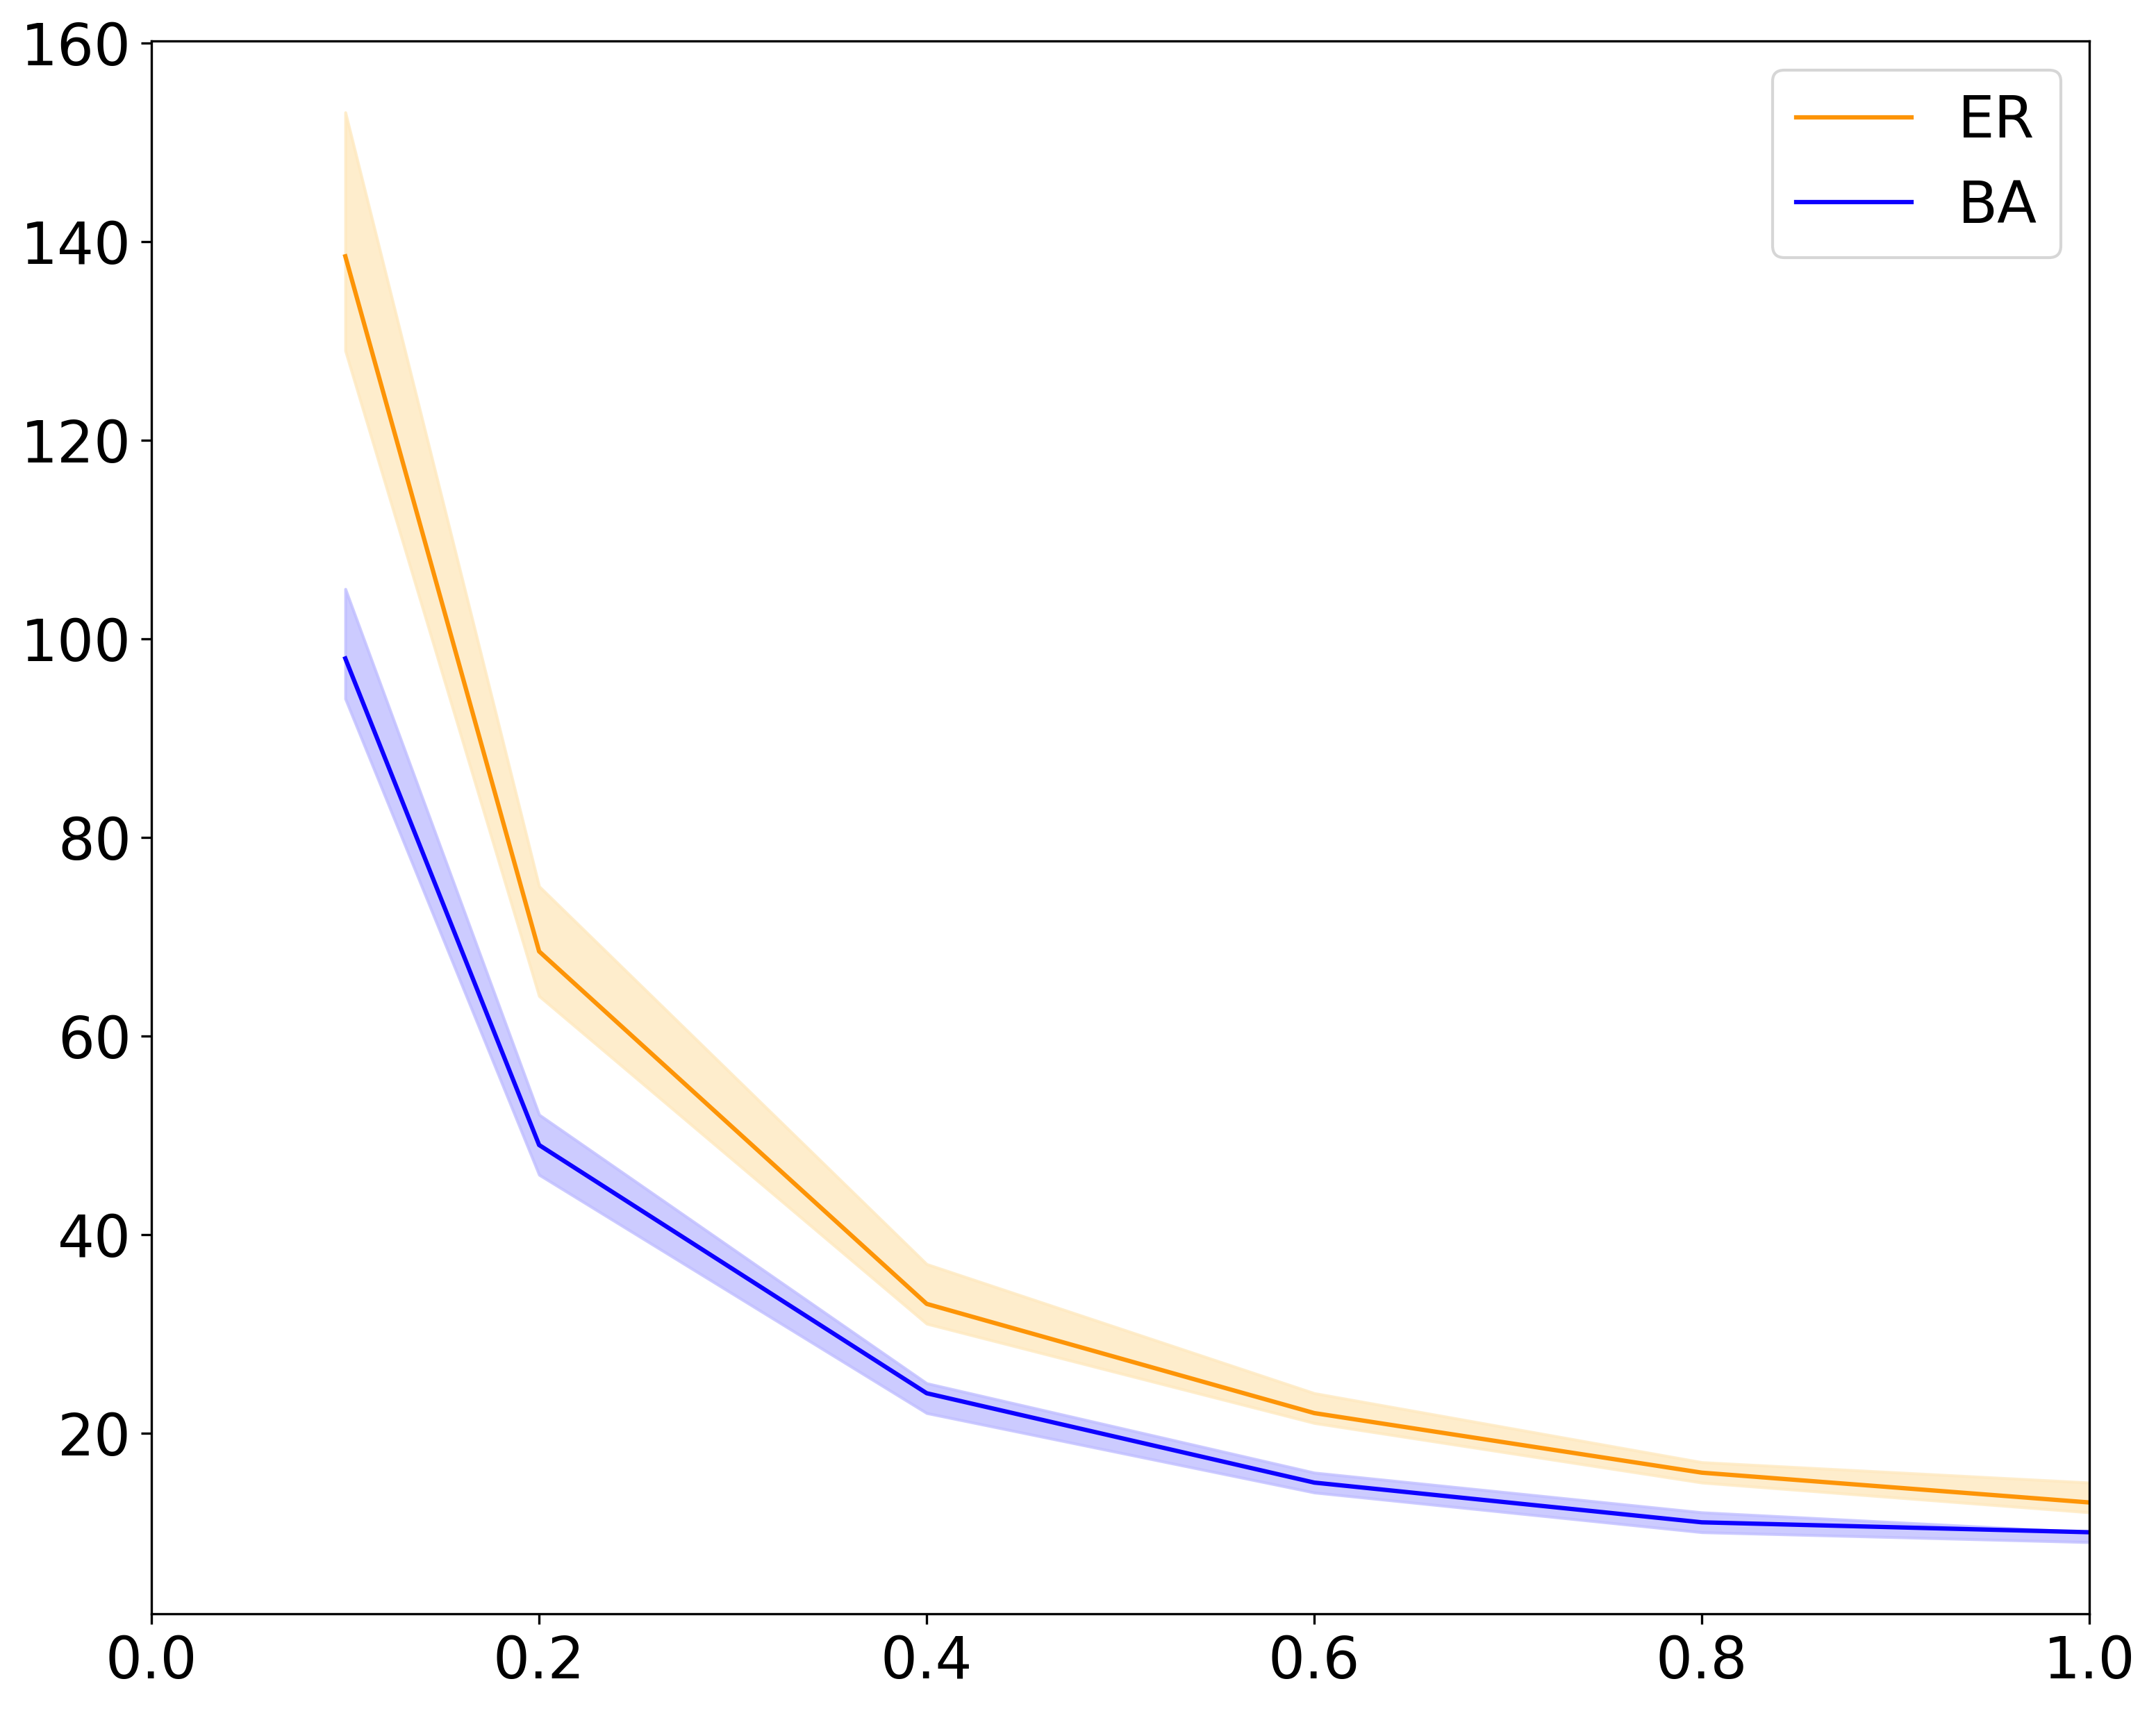

In [8]:
figure(figsize=(12,10), dpi=300)
plt.plot(p_out_list, end_time_median_ER, '-', color='#FD9406', label='ER')
plt.fill_between(p_out_list, end_time_5_percentile_ER, end_time_95_percentile_ER,color='#FEE9C0', alpha=0.8)
plt.plot(p_out_list, end_time_median_BA, '-', color='#0D00FF', label='BA')
plt.fill_between(p_out_list, end_time_5_percentile_BA, end_time_95_percentile_BA,color='#C0BEFF', alpha=0.8)
plt.xlim(0, 1)
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('figure-4a.png')
plt.show()